# Predicting Red Hat Business Value 

## 목표
* Linux 보안 서비스를 제공하는 Red Hat 사의 마스킹 처리된 고객 데이터를 통해 잠재 비즈니스 가치가 높은 고객을 분류하는 알고리즘 생성
  * act_test 내 'activity_id' 의 outcome(0 or 1 로 구성)을 예측

### 제공된 데이터

* ** people.csv **
    * rows, columns = 189,118 / 41
    * column의 구성
        * people_id: 189,118명 
        * char_1: type 2
        * group_1: 34,224 group
        * char_2: 3 type
        * date: 1,196 days
        * char_3 : 43 type
        * char_4 : 25 type
        * char_5 : 9 type
        * char_6 : 7 type
        * char_7 : 25 type
        * char_8 : 8 type
        * char_9 : 9 type
        * char_10 ~ char_37: boolean
        * char_38: Numerical(Continuous)

* ** act_train.csv ** 
  * rows, columns = 2,197,291, 15
  * column의 구성
    * people_id : 151,295    
    * activity_id : 2,197,291
    * date : 411 days
    * activity_category : 7
    * char_1 : 52 categories
    * char_2 : 33 categories
    * char_3 : 12 categories
    * char_4 : 8 categories
    * char_5 : 8 categories
    * char_6 : 6 categories
    * char_7 : 9 categories
    * char_8 : 19 categories
    * char_9 : 20 categories
    * char_10 : 6516 categories
    * outcome : 2 (0, 1)

* ** act_test.csv ** 
  * rows, columns = 498,687 / 14
  * column의 구성
    * people_id : 37,823   
    * activity_id : 498,687
    * date : 411 days
    * activity_category : 7 type
    * char_1 : 49 type
    * char_2 : 32 type
    * char_3 : 12 type
    * char_4 : 8 type
    * char_5 : 7 type
    * char_6 : 6 type
    * char_7 : 9 type
    * char_8 : 19 type
    * char_9 : 20 type
    * char_10 : 3962 type

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['figure.figsize'] = (8, 5)

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import binarize
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier


import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz


pd.options.display.max_columns = 400
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 600
pd.options.display.precision = 10

C:\Users\tjdal\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [110]:
train = pd.read_csv('./__data/act_train.csv', parse_dates=['date'])
test = pd.read_csv('./__data/act_test.csv', parse_dates=['date'])
ppl = pd.read_csv('./__data/people.csv', parse_dates=['date'])

In [4]:
df_train = pd.merge(train, ppl, on='people_id', suffixes=('_act', '_ppl'))
df_test = pd.merge(test, ppl, on='people_id', suffixes=('_act', '_ppl'))

In [108]:
del train, test, ppl

In [7]:
df_train.tail(3)

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,char_1_ppl,group_1,char_2_ppl,date_ppl,char_3_ppl,char_4_ppl,char_5_ppl,char_6_ppl,char_7_ppl,char_8_ppl,char_9_ppl,char_10_ppl,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 199,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95
2197290,ppl_99994,act2_715089,2023-06-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,type 2,type 2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,95


In [8]:
df_test.tail(3)

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,char_1_ppl,group_1,char_2_ppl,date_ppl,char_3_ppl,char_4_ppl,char_5_ppl,char_6_ppl,char_7_ppl,char_8_ppl,char_9_ppl,char_10_ppl,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
498684,ppl_99997,act2_448830,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,type 2,group 17304,type 2,2022-03-12,type 40,type 25,type 9,type 3,type 8,type 6,type 6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,36
498685,ppl_99997,act2_450133,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,type 2,group 17304,type 2,2022-03-12,type 40,type 25,type 9,type 3,type 8,type 6,type 6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,36
498686,ppl_99997,act2_847967,2022-10-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,type 2,group 17304,type 2,2022-03-12,type 40,type 25,type 9,type 3,type 8,type 6,type 6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,36


# 1. EDA

* train data / test data 의 date feature 의 분포 확인

In [9]:
for d in ['date_act', 'date_ppl']:
    print('Start of ' + d + ': ' + str(df_train[d].min().date()))
    print('  End of ' + d + ': ' + str(df_train[d].max().date()))
    print('Range of ' + d + ': ' + str(df_train[d].max() - df_train[d].min()) + '\n')

Start of date_act: 2022-07-17
  End of date_act: 2023-08-31
Range of date_act: 410 days 00:00:00

Start of date_ppl: 2020-05-18
  End of date_ppl: 2023-08-31
Range of date_ppl: 1200 days 00:00:00



In [10]:
def cleansing_data(train, test):
    
    # 'activity_id' feature 를 act1 / act2 에 따라 1 / 2 로 구분
    for table in [train, test]:
        ait = pd.DataFrame([item[0].lstrip('act') for item in table['activity_id'].str.split('_')])
        table.insert(1, 'activity_id_type', ait)
     
    # 연/월/일 이 합쳐있는 기존의 date feature 를 연/월/일/요일 로 구분
    for table in [train, test]:
        
        table.insert(3, 'year_act', table['date_act'].dt.year)
        table.insert(4, 'month_act',table['date_act'].dt.month)
        table.insert(5, 'day_act', table['date_act'].dt.day)
        table.insert(6, 'weekday_act', table['date_act'].dt.weekday)
    
        table.insert(19, 'year_ppl', table['date_ppl'].dt.year)
        table.insert(20, 'month_ppl', table['date_ppl'].dt.month)
        table.insert(21, 'day_ppl', table['date_ppl'].dt.day)
        table.insert(22, 'weekday_ppl', table['date_ppl'].dt.weekday)
    
        # 'group_1' / 'people_id' feature 의 string 을 제거
        table['group_1'] = table['group_1'].str.lstrip('group')
        table['people_id'] = table['people_id'].str.lstrip('ppl_')
    
        # 처음 가입 후 첫 행동을 하기까지의 기간을 생성
        table['from_join_to_act'] = (table['date_act'] - table['date_ppl']).astype('timedelta64[D]')
     
        # 'activity_id' feature 의 string 을 제거하여 숫자만 구성
        table['activity_id'] = table['activity_id'].str.lstrip('act2_')
        table['activity_id'] = table['activity_id'].str.lstrip('act1_')
        
        
        # 사용되지 않는 기존의 date feature 삭제
        del table['date_act']
        del table['date_ppl']
        
        # NaN value 0 으로 대체 (type0 으로 지정)
        table.fillna(0, inplace=True)
              
    # boolean type feature 는 모두 0 or 1 로 encoding
    features = ['char_{}'.format(i) for i in range(11, 38)]
    features.insert(0, 'char_10_ppl')
    
    # Memory Error 로 한번에 실행 불가
#     # 나머지 존재하는 모든 string 제거 (type)
#     df_train = df_train.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')
#     df_test = df_test.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')

    tf_map = {True: 0, False: 1}
    for table in [train, test]:
        for feature in features:
            table[feature] = table[feature].map(tf_map)
            
    return None

In [11]:
%%time
cleansing_data(df_train, df_test)

Wall time: 33.4 s


In [12]:
%%time
df_train = df_train.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')
df_test = df_test.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')

Wall time: 2min 32s


In [13]:
df_train.tail(3)

,people_id,activity_id_type,activity_id,year_act,month_act,day_act,weekday_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,year_ppl,month_ppl,day_ppl,weekday_ppl,outcome,char_1_ppl,group_1,char_2_ppl,char_3_ppl,char_4_ppl,char_5_ppl,char_6_ppl,char_7_ppl,char_8_ppl,char_9_ppl,char_10_ppl,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,from_join_to_act
2197288,99994.0,2,536973,2023,1,19,3,2,0,0,0,0,0,0,0,0,0,1,2023,1,6,4,1,2,17764,3,2,7,2,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,95,13.0
2197289,99994.0,2,688656,2023,5,2,1,4,0,0,0,0,0,0,0,0,0,199,2023,1,6,4,1,2,17764,3,2,7,2,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,95,116.0
2197290,99994.0,2,715089,2023,6,15,3,2,0,0,0,0,0,0,0,0,0,1,2023,1,6,4,1,2,17764,3,2,7,2,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,95,160.0


### 'people_id' 와 'activity_id' 의 관계 확인

* (1) 평균적인 하나의 'people_id' 당 'activity_id' 의 수 확인

In [49]:
# people_id 당 activity_id 의 분포 확인
# 최대 한사람이 50,000회 의상의 activity를 함.
# 24918, 370270, 105739, 54699 를 주목 할 필요
threshold = 400
peoples = df_train['people_id']
people_counts = peoples.value_counts()
people_counts[people_counts > threshold].plot(kind='bar')
plt.title('People with more than {} activities'.format(threshold))
plt.ylabel('Activity count')
fig = plt.gcf()
fig.set_size_inches(16, 7)
peoples_test = df_test['people_id']
print("="*20,"train data","="*20)
print("Number of active people: {}".format(peoples.nunique()),'\n', "average participation rate per person: {}".format(df_train['activity_id'].nunique()/peoples.nunique()))
print()
print("="*20,"test data","="*20)
print("Number of active people: {}".format(peoples_test.nunique()), '\n', "average participation rate per person: {}".format(df_test['activity_id'].nunique()/peoples_test.nunique()))

==================== train data ====================
Number of active people: 151295 
 average participation rate per person: 10.385908324795928

==================== test data ====================
Number of active people: 37823 
 average participation rate per person: 11.644687095153742


* 'people_id' 당 'activity_id' 의 분포 확인
* 최대 한사람이 50,000회 의상의 activity를 가지고 있음

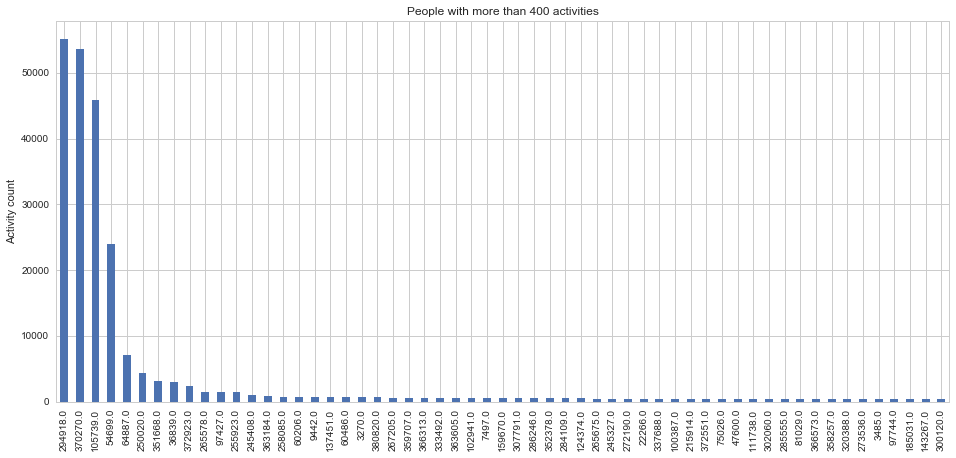

In [16]:
threshold = 400
people_counts = peoples.value_counts()
people_counts[people_counts > threshold].plot(kind='bar')
plt.title('People with more than {} activities'.format(threshold))
plt.ylabel('Activity count')
fig = plt.gcf()
fig.set_size_inches(16, 7)
plt.show()

* 'people_id' 당 'activity_id' 10개 이하의 activity를 갖는 사람이 70% 가량

==================== Ratio of less than 10 ====================
ratio of less than 10 : 69.14 %


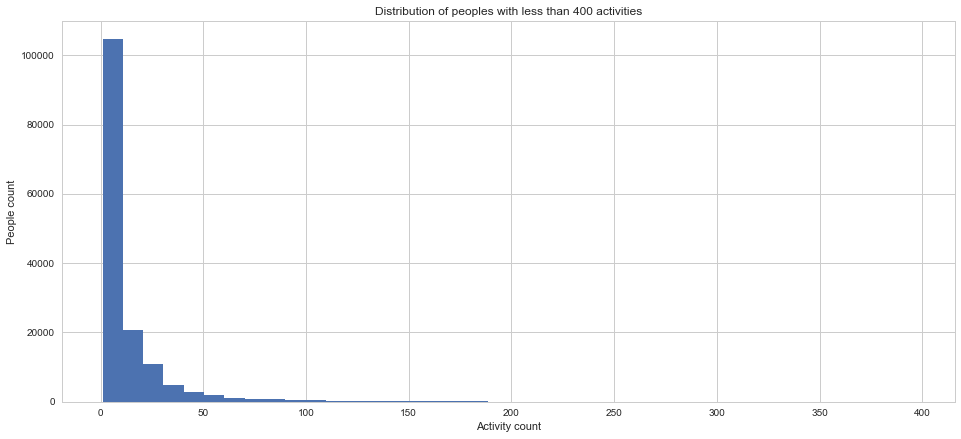

In [86]:
print('='*20,'Ratio of less than 10','='*20)
act_10_count = (df_train.groupby('people_id')['activity_id'].count() <= 10).value_counts()
act_10_rate = round(act_10_count[True]/act_10_count.sum()*100, 2)
print('ratio of less than 10 :', act_10_rate, "%")

threshold = 400
peoples = df_train['people_id']
people_counts = peoples.value_counts()
people_counts[people_counts <= threshold].hist(bins=int(threshold / 10))
plt.xlabel('Activity count')
plt.ylabel('People count')
plt.title('Distribution of peoples with less than {} activities'.format(threshold))
# plt.xlim(0, 50)
fig = plt.gcf()
fig.set_size_inches(16, 7)
plt.show()

### 'people_id' 특성 확인

* 'people_id' 와 target feature 인 'outcome' 의 관계 확인

==================== People_id Distribution ====================
only 0 people_id : 54.55 %
only 1 people_id : 41.06 %
mixed people_id : 4.4 %


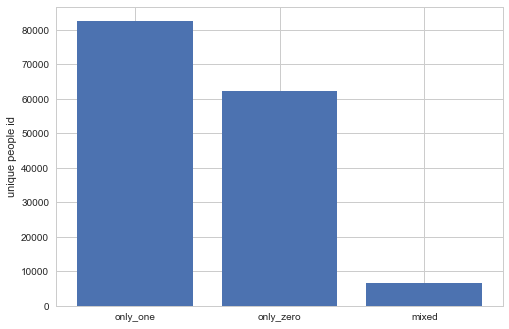

In [45]:
print('='*20,'People_id Distribution','='*20)
people_0 = (df_train.groupby('people_id')['outcome'].mean() == 0).value_counts()
print('only 0 people_id',":",round(people_0[True]/people_0.sum()*100, 2)   ,"%")

people_1 = (df_train.groupby('people_id')['outcome'].mean() == 1).value_counts()
print('only 1 people_id :', round(people_1[True]/people_1.sum()*100, 2)  ,"%")

people_mix = ((df_train.groupby('people_id')['outcome'].mean() < 1) & (df_train.groupby('people_id')['outcome'].mean() > 0)).value_counts()
print("mixed people_id :", round(people_mix[True]/people_mix.sum()*100, 2), "%")

only_0 = int(people_0[True])
only_1 = int(people_1[True])
mixed = int(people_0.sum() - (only_0+only_1))

y = [only_0, only_1, mixed]
x = [0, 1, 2]
plt.bar(x, y)
plt.xticks(x, ('only_one', 'only_zero', 'mixed'))
plt.ylabel('unique people id')
plt.show()

### 'group_1' feature 확인

* group 별 people_id가 많은 상위 20개 확인
* 17304가 약 80만개의 peopel_id를 보유, 모든 outcom 0 (추후 다중공선성 확인 필요)

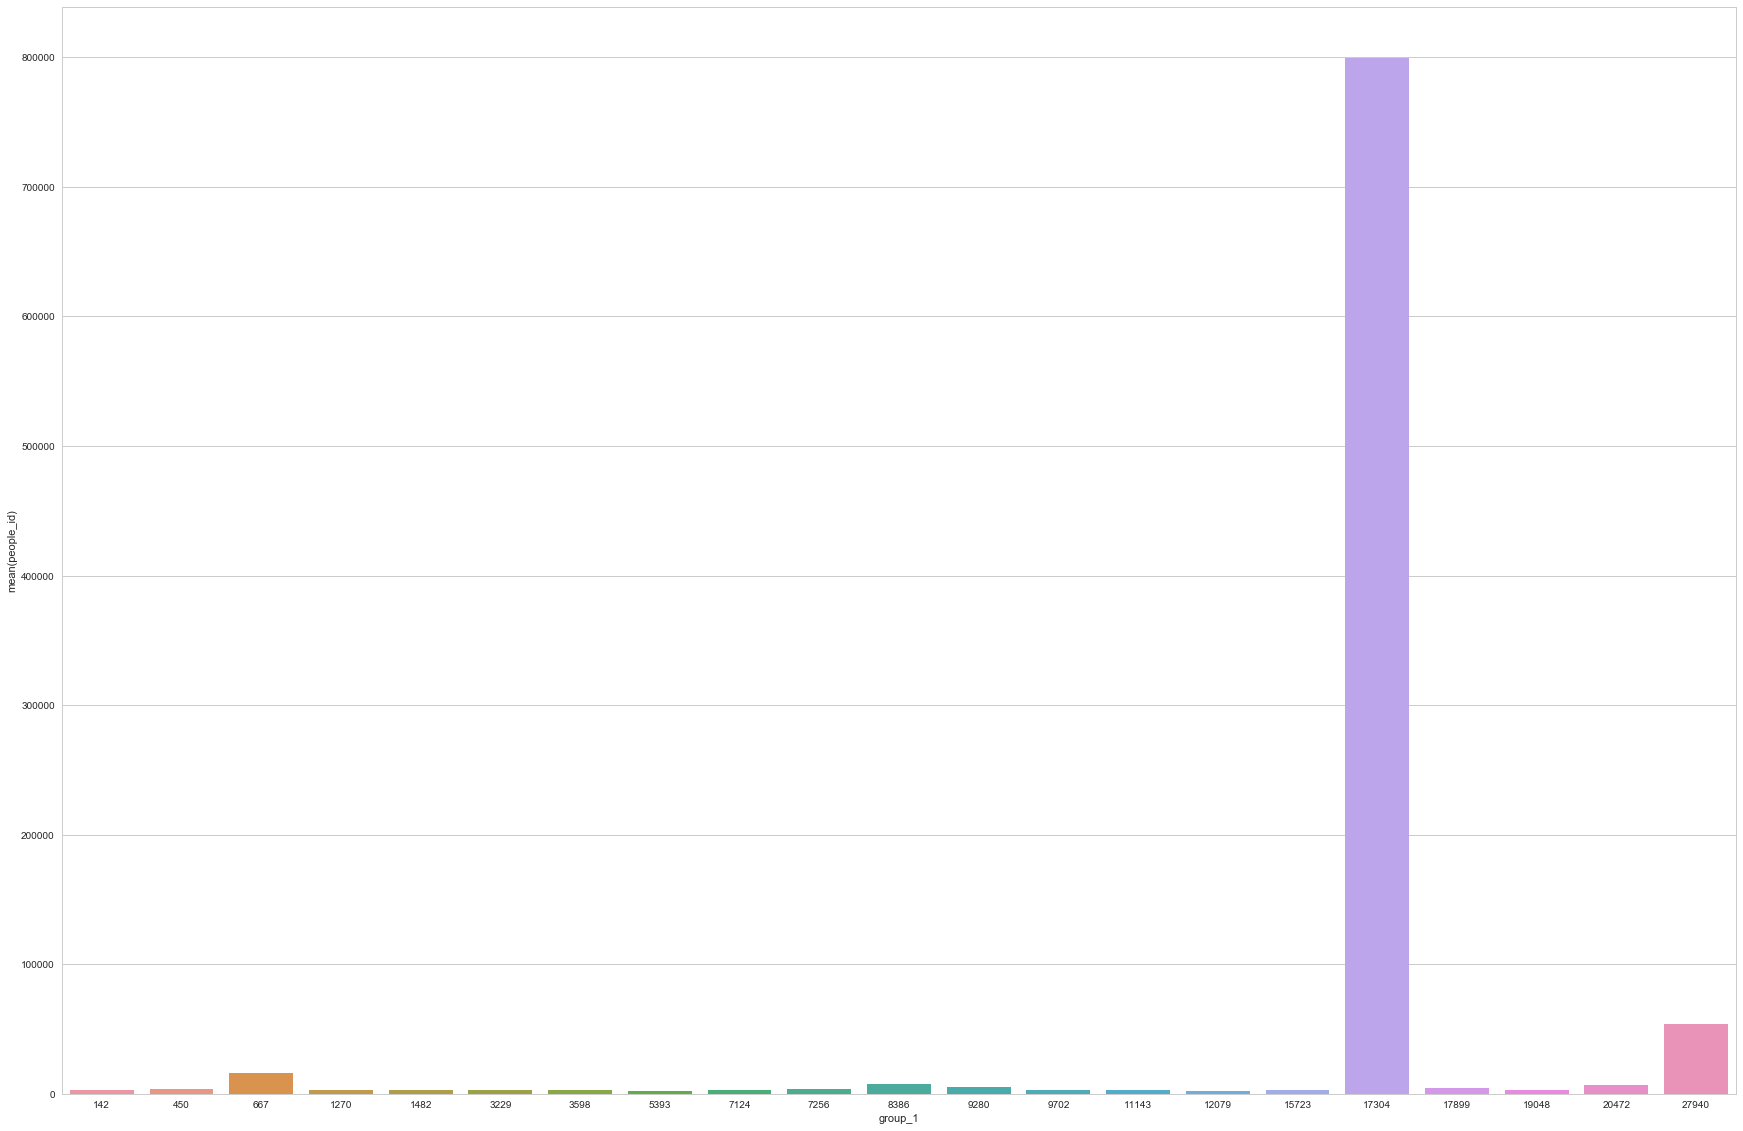

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 20)

group_based_ppl_count = df_train.groupby(['group_1']).count().sort_values(by='people_id',ascending=[0])
group_based_ppl_count = group_based_ppl_count.reset_index()
group_based_ppl_count = group_based_ppl_count.loc[:20,]

g = sns.barplot(x='group_1',y='people_id',data=group_based_ppl_count,ax=ax)
plt.show(0)

* train data 와 test data 내의 'group_1' feature 의 분포 비교
    * 거의 동일한 형태의 분포를 이루고 있는 것 확인

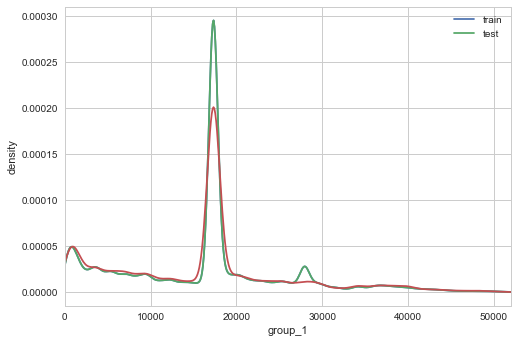

In [93]:
df_train['group_1'].plot(kind='density')
df_test['group_1'].plot(kind='density')
plt.legend(['train', 'test'])
plt.xlim(0, 52000)
plt.xlabel('group_1')
plt.ylabel('density')
plt.show()

### 'char_38' feature 확인

* 특정 수치를 기준으로 outcome 이 비교적 명확하게 분포해있음 확인

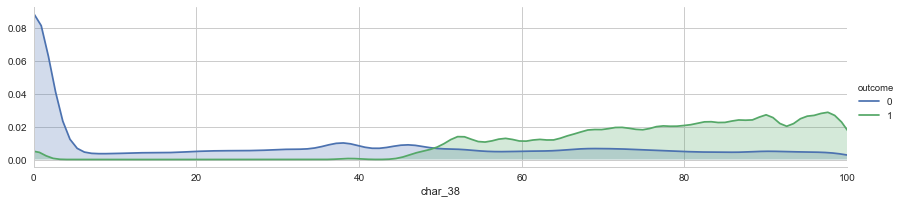

In [91]:
facet = sns.FacetGrid(df_train, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_train['char_38'].max()))
facet.add_legend()

plt.show()